<a href="https://colab.research.google.com/github/ZhengyiGuo2002/CSDM-code/blob/main/CSDM_OCTMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
import numpy as np
import random
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Subset
from torchvision.utils import make_grid
from tqdm import tqdm


Set random seed in order to produce consistent results

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2025)

In [3]:
# SDE Utilities (VE)
def marginal_prob_std(t, sigma):
    if isinstance(t, torch.Tensor):
        t = t.clone().detach()
    else:
        t = torch.tensor(t, device='cpu')

    return torch.sqrt((sigma ** (2 * t) - 1.) / (2. * np.log(sigma)))


def diffusion_coeff(t, sigma):
    return sigma ** t


def loss_fn(model, x, marginal_prob_std_fn, eps=1e-5, num_steps=1000):
    """
    Denoising Score Matching
    """
    batch_size = x.shape[0]
    device = x.device

    # sample random t ∈ (eps, 1]
    random_t = torch.rand(batch_size, device=device) * (1. - eps) + eps

    z = torch.randn_like(x)

    std = marginal_prob_std_fn(random_t)[:, None, None, None]  # shape: [B, 1, 1, 1]
    x_perturbed = x + z * std

    # As we want to apply UNet, which is in discrete form, we need to map continuous time into discrete
    timesteps = (random_t * (num_steps - 1)).long()

    # score
    score_pred = model(x_perturbed, timesteps).sample
    # DSM loss
    loss = torch.mean(torch.sum((score_pred * std + z) ** 2, dim=(1, 2, 3)))

    return loss


def Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                           batch_size=64, num_steps=1000, device='cuda', eps=1e-5):
    """
    Apply Euler–Maruyama to sample
    """
    # sample from rando noise at T
    t_init = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std_fn(t_init)[:, None, None, None]
    x = init_x

    # produce reverse time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]

    with torch.no_grad():
        for time in time_steps:
            batch_t = torch.full((batch_size,), time, device=device)
            g = diffusion_coeff_fn(batch_t)[:, None, None, None]

            timesteps = (batch_t * (num_steps - 1)).long()
            score = score_model(x, timesteps).sample
            mean_x = x + (g ** 2) * score * step_size
            x = mean_x + torch.sqrt(step_size) * g * torch.randn_like(x)

    return mean_x # last step we don't use noise

OCTMNIST is in medmnist

In [4]:
pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 11.9 MB/s eta 0:00:00


Here we clean the data only keeping those images with high sparsity, and also boost lightness and darkness

Sparsity Calculation: 100%|██████████| 97477/97477 [00:47<00:00, 2045.65it/s]


total images: 97477
average sparsity: 0.6138
maximal sparsity: 0.9812
minimal sparsity: 0.0000
number of images with sparsity > 70% is: 25337


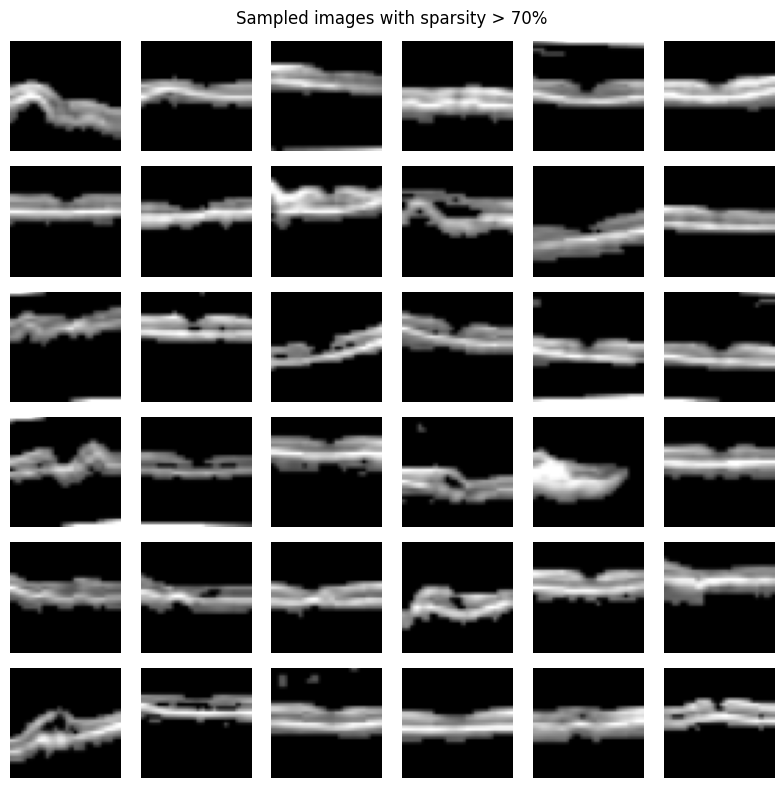

In [14]:
import medmnist
from medmnist import INFO, OCTMNIST
from medmnist import Evaluator

def boost_high_suppress_low(x, alpha=3, beta=0.2):
    x_new = x.clone()
    x_new[x > 0.15] = torch.clamp(x_new[x > 0.15] * alpha, 0, 1)
    x_new[x <= 0.15] = x_new[x <= 0.15] * beta
    return x_new


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: boost_high_suppress_low(x, alpha=2, beta=0)),
    transforms.Resize((40, 40))
])

dataset = OCTMNIST(split='train', transform=transform, download=True)


sparsity_list = []
sparse_indices = []

# thresholds to filter dataset
pixel_threshold = 0.2
sparsity_threshold = 0.7

for i in tqdm(range(len(dataset)), desc="Sparsity Calculation"):
    img, _ = dataset[i]
    flat = img.view(-1)
    sparsity = torch.mean((flat < pixel_threshold).float()).item()
    sparsity_list.append(sparsity)

    if sparsity > sparsity_threshold:
        sparse_indices.append(i)

sparsity_array = np.array(sparsity_list)

print(f"total images: {len(dataset)}")
print(f"average sparsity: {sparsity_array.mean():.4f}")
print(f"maximal sparsity: {sparsity_array.max():.4f}")
print(f"minimal sparsity: {sparsity_array.min():.4f}")
print(f"number of images with sparsity > {int(sparsity_threshold*100)}% is: {len(sparse_indices)}")

sparse_subset = Subset(dataset, sparse_indices)

# visualization
n_show = 36
fig, axs = plt.subplots(6, 6, figsize=(8, 8))
for i in range(n_show):
    img, _ = sparse_subset[i]
    axs[i // 6][i % 6].imshow(img.squeeze(), cmap='gray')
    axs[i // 6][i % 6].axis('off')

plt.suptitle(f'Sampled images with sparsity > {int(sparsity_threshold*100)}%')
plt.tight_layout()
plt.show()

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# random matrix setting
m, d = 28*28, 40*40
A = torch.randn(m, d, device=device) * (2.0 / np.sqrt(m))

medmnist.DATASET_DIR = './data/medmnist'

class CompressedOCTMNIST(Dataset):
    def __init__(self, split='train', download=True, pixel_threshold=0.2, sparsity_threshold=0.7):
        data_flag = 'octmnist'
        info = INFO[data_flag]
        self.A = A.cpu()
        self.filtered_data = []

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: boost_high_suppress_low(x, alpha=2, beta=0)),
            transforms.Resize((40, 40))
        ])

        raw_dataset = OCTMNIST(
            split=split,
            transform=transform,
            download=download,
        )

        for i in range(len(raw_dataset)):
            img, label = raw_dataset[i]
            flat = img.view(-1)
            sparsity = torch.mean((flat < pixel_threshold).float()).item()
            if sparsity >= sparsity_threshold:
                self.filtered_data.append((img, label))

        print(f"number of images with sparsity ≥ {int(sparsity_threshold * 100)}% is: {len(self.filtered_data)}")

        # take a look at mean and std, we found that unnormalized version is better
        all_y = []
        for img, _ in self.filtered_data:
            x = img.view(-1)
            y = self.A @ x
            all_y.append(y)
        all_y = torch.cat(all_y, dim=0)
        self.mean = all_y.mean()
        self.std = all_y.std()

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, idx):
        img, _ = self.filtered_data[idx]
        x = img.view(-1)
        y = self.A @ x
        y_img = y.view(1, 28, 28)
        return y_img

train_ds = CompressedOCTMNIST(split='train', download=True)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)

# Model
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128, 256, 512),
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
).to(device)

global_mean = train_ds.mean
global_std = train_ds.std
print(f"global mean={global_mean:.4f}, global std={global_std:.4f}")

number of images with sparsity ≥ 70% is: 25337
global mean=-0.0056, global std=0.8583


In [11]:
def fista(y, A, lam=1e-4, L=None, max_iter=500, tol=1e-5):
    """
    Solve  min_x  1/2||Ax - y||^2 + lam*||x||_1
    via FISTA, with early stopping.
    """
    m, d = A.shape
    if L is None:
        L = torch.linalg.norm(A, ord=2) ** 2

    x = torch.zeros(d, device=A.device)
    z = x.clone()
    t = 1.0

    for k in range(max_iter):
        grad = A.t() @ (A @ z - y)
        x_new = torch.sign(z - grad / L) * torch.clamp(torch.abs(z - grad / L) - lam / L, min=0)

        delta = torch.norm(x_new - x)
        if delta < tol:
            print(f"Early stopped at iter {k+1}, Δx = {delta:.2e}")
            break

        t_new = 0.5 * (1 + np.sqrt(1 + 4 * t**2))
        z = x_new + ((t - 1) / t_new) * (x_new - x)
        x, t = x_new, t_new

    return x

In [ ]:
sigma = 20.0
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# auto-adjust learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for x in train_loader:
        x = x.to(device)
        loss = loss_fn(model, x, lambda t: marginal_prob_std(t, sigma))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    scheduler.step(avg_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1}: avg_train_loss = {avg_loss:.4f}, lr = {current_lr:.6f}")

Epoch 1: avg_train_loss = 45.2262, lr = 0.000200
Epoch 2: avg_train_loss = 44.6680, lr = 0.000200
Epoch 3: avg_train_loss = 43.5235, lr = 0.000200
Epoch 4: avg_train_loss = 43.8998, lr = 0.000200
Epoch 5: avg_train_loss = 43.7956, lr = 0.000200
Epoch 6: avg_train_loss = 43.2285, lr = 0.000200
Epoch 7: avg_train_loss = 43.0282, lr = 0.000200
Epoch 8: avg_train_loss = 43.1560, lr = 0.000200
Epoch 9: avg_train_loss = 41.8570, lr = 0.000200
Epoch 10: avg_train_loss = 42.4037, lr = 0.000200
Epoch 11: avg_train_loss = 41.5300, lr = 0.000200
Epoch 12: avg_train_loss = 42.3218, lr = 0.000200
Epoch 13: avg_train_loss = 40.8813, lr = 0.000200
Epoch 14: avg_train_loss = 41.4701, lr = 0.000200


In [ ]:
import os
import time
from PIL import Image

save_dir = "/content/recovered_images"
os.makedirs(save_dir, exist_ok=True)

total_samples = 64
batch_size = 16
num_batches = total_samples // batch_size
counter = 0

sampling_time = 0.0
recovery_time = 0.0

preview_images = []

model.eval()
for b in tqdm(range(num_batches), desc="Processing Batches"):
    # sampling on low dimension
    start_sample = time.time()
    with torch.no_grad():
        compressed = Euler_Maruyama_sampler(
            model,
            lambda t: marginal_prob_std(t, sigma),
            lambda t: diffusion_coeff(t, sigma),
            batch_size=batch_size,
            device=device
        )
    end_sample = time.time()
    sampling_time += (end_sample - start_sample)

    # Recovery via FISTA
    for y_img in compressed:
        start_recover = time.time()
        y_vec = y_img.view(-1).to(device)
        x_rec = fista(y_vec, A, lam=2e-4, max_iter=500, tol=1e-5)
        x_rec = x_rec.view(40, 40).cpu().numpy()
        x_rec = np.clip(x_rec, 0, 1)
        end_recover = time.time()
        recovery_time += (end_recover - start_recover)

        # save to PNG
        img_uint8 = (x_rec * 255).astype(np.uint8)
        pil_img = Image.fromarray(img_uint8, mode='L')
        pil_img.save(f"{save_dir}/{counter:05d}.png")

        # visualization
        if counter < 36:
            preview_images.append(x_rec)

        counter += 1


print(f"\n✅ Sampling Time Total: {sampling_time:.2f} seconds")
print(f"✅ Recovery Time Total: {recovery_time:.2f} seconds")
print(f"✅ Saved to: {save_dir}")

plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(preview_images[i], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.tight_layout()
plt.show()